In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class TwoCompartmentLIFLayer(nn.Module):
    def __init__(self, n_in, n_out, t_mem, t_ref, rho):
        super().__init__()
        
        self.linear = nn.Linear(n_in, n_out, bias=False)
        self.alpha_mem = 1./t_mem
        self.alpha_ref = 1./t_ref
        self.rho = rho
        
        self.reset()
        
    def threshold(self, u):
        return (u >= 1.).float()
        
    def forward(self, x):
        input_ = self.linear(x)
        
        if self.R is None:
            self.R = torch.zeros_like(input_, requires_grad=False)
            self.V = torch.zeros_like(input_, requires_grad=False)

        self.V += (-self.V + input_) * self.alpha_mem
        self.U = self.V - self.rho * self.R
        spikes_out = self.threshold(self.U)
        self.R += (-self.R + spikes_out) * self.alpha_ref
        return spikes_out
    
    def set_target(self, By, x):
        self.linear.weight.grad = (self.V - By).T @ x
        
    def reset(self):
        self.R = None
        self.V = None


In [3]:
def img_to_poisson(img, n_steps, max_rate=1.):
    # assuming 0 <= img <= 1
    img = img.flatten(start_dim=1)
    spikes = torch.rand(n_steps, *img.shape, device=img.device) < img * max_rate
    return spikes.moveaxis(0, 1).float()

## Learning test

In [4]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm

ds = MNIST(root="~/Work/datasets/", transform=ToTensor())
dl = torch.utils.data.DataLoader(ds, batch_size=1000, shuffle=True)
ds_test = MNIST(root="~/Work/datasets/", transform=ToTensor(), train=False)
dl_test = torch.utils.data.DataLoader(ds, batch_size=1000, shuffle=True)

device = "cuda"

In [5]:
n_in = 784
n_out = 10

tottime = 100
MAX_RATE = 0.4

layer = TwoCompartmentLIFLayer(n_in, n_out, t_mem=20., t_ref=5., rho=20.).to(device)

With t_ref=2, rho=15, we have most neurons spiking exactly 50% of the time. Why is that? Why is there this flattening effect on one side of rho and WTA on the other side??

Why large rho lowers the max is clear. But why does it also increase the min firing rate?

In [6]:
optimizer = torch.optim.Adam(layer.linear.parameters(), lr=1e-2/tottime, weight_decay=1e-8)

for img, label in tqdm(dl):
    img = img_to_poisson(img.to(device), tottime, max_rate=MAX_RATE)
    target = torch.nn.functional.one_hot(label.to(device), 10)
    
    for t in range(tottime):
        current_input = img[:, t]
        layer(current_input)
        layer.set_target(target*5., current_input)
        
        optimizer.step()
        optimizer.zero_grad()
    layer.reset()

100%|██████████| 60/60 [00:08<00:00,  6.90it/s]


In [7]:
tot_correct = 0
tot_seen = 0
n_zeros = 0

pbar = tqdm(dl_test)
layer.reset()

for img, label in pbar:
    with torch.no_grad():
        tot_seen += len(label)
        out = 0.
        img = img_to_poisson(img.to(device), tottime, max_rate=MAX_RATE)

        for t in range(tottime):
            out += layer(img[:, t])


        correct = torch.max(out, 1)[1] == label.to(device)
        n_zeros += (out.sum(1) == 0.).sum().item()
        tot_correct += correct.sum().item()
        pbar.set_postfix(running_accuracy=tot_correct/tot_seen,
                         frac_no_spk=n_zeros/tot_seen)
        print(out[0])

  3%|▎         | 2/60 [00:00<00:06,  8.56it/s, frac_no_spk=0.0005, running_accuracy=0.826]

tensor([ 0.,  8.,  0.,  0., 13.,  0.,  4., 13.,  0.,  0.], device='cuda:0')
tensor([12.,  0.,  7.,  0., 13.,  0.,  0.,  1.,  0.,  5.], device='cuda:0')


  7%|▋         | 4/60 [00:00<00:06,  8.74it/s, frac_no_spk=0.00025, running_accuracy=0.835]

tensor([19.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0')
tensor([32.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')


 10%|█         | 6/60 [00:00<00:06,  8.79it/s, frac_no_spk=0.000167, running_accuracy=0.832]

tensor([16.,  0., 13.,  0.,  0., 11.,  0., 11., 11.,  0.], device='cuda:0')
tensor([ 1., 15.,  7.,  0.,  0.,  0.,  0.,  1., 10.,  0.], device='cuda:0')


 13%|█▎        | 8/60 [00:00<00:05,  8.72it/s, frac_no_spk=0.000125, running_accuracy=0.83] 

tensor([ 0.,  1., 18.,  0.,  0.,  0.,  0., 10.,  6.,  0.], device='cuda:0')
tensor([ 9.,  0., 20.,  0.,  0.,  4.,  0., 12.,  0.,  8.], device='cuda:0')


 17%|█▋        | 10/60 [00:01<00:05,  8.74it/s, frac_no_spk=0.0001, running_accuracy=0.833] 

tensor([0., 8., 8., 0., 1., 0., 0., 1., 0., 7.], device='cuda:0')
tensor([0., 1., 0., 0., 0., 9., 0., 5., 8., 0.], device='cuda:0')


 20%|██        | 12/60 [00:01<00:05,  8.72it/s, frac_no_spk=8.33e-5, running_accuracy=0.833]

tensor([0., 0., 0., 0., 0., 9., 0., 0., 6., 3.], device='cuda:0')
tensor([21.,  0.,  0.,  5.,  0.,  2.,  0.,  0.,  2.,  0.], device='cuda:0')


 23%|██▎       | 14/60 [00:01<00:05,  8.77it/s, frac_no_spk=7.14e-5, running_accuracy=0.835]

tensor([2., 2., 9., 0., 0., 0., 6., 0., 0., 0.], device='cuda:0')
tensor([ 4.,  0.,  1.,  0.,  0., 16.,  1.,  0.,  8.,  0.], device='cuda:0')


 27%|██▋       | 16/60 [00:01<00:05,  8.79it/s, frac_no_spk=6.25e-5, running_accuracy=0.836]

tensor([ 0.,  0.,  0.,  6.,  0., 13.,  0.,  0.,  2.,  2.], device='cuda:0')
tensor([ 0., 18.,  0.,  0.,  0.,  1.,  0.,  0.,  5.,  0.], device='cuda:0')


 30%|███       | 18/60 [00:02<00:04,  8.75it/s, frac_no_spk=0.000111, running_accuracy=0.835]

tensor([ 0.,  8.,  0.,  0.,  2.,  0.,  0.,  0.,  0., 16.], device='cuda:0')
tensor([22.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.], device='cuda:0')


 33%|███▎      | 20/60 [00:02<00:04,  8.78it/s, frac_no_spk=0.0001, running_accuracy=0.835]  

tensor([ 2.,  0.,  0., 12.,  6.,  9.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([ 0.,  0.,  0., 25.,  0.,  1.,  0.,  0.,  0.,  0.], device='cuda:0')


 37%|███▋      | 22/60 [00:02<00:04,  8.80it/s, frac_no_spk=9.09e-5, running_accuracy=0.834]

tensor([ 0.,  0.,  0., 13.,  0., 18.,  0.,  0.,  1.,  0.], device='cuda:0')
tensor([ 0.,  0.,  0.,  0.,  0.,  1.,  0., 18.,  0.,  0.], device='cuda:0')


 40%|████      | 24/60 [00:02<00:04,  8.81it/s, frac_no_spk=8.33e-5, running_accuracy=0.835]

tensor([ 0.,  7.,  0.,  0., 15.,  0.,  0.,  8.,  0.,  4.], device='cuda:0')
tensor([ 0.,  1.,  0.,  0.,  1.,  0., 18.,  0.,  0.,  0.], device='cuda:0')


 43%|████▎     | 26/60 [00:02<00:03,  8.75it/s, frac_no_spk=7.69e-5, running_accuracy=0.835]

tensor([ 0.,  9.,  0.,  0.,  0., 14.,  2.,  0.,  0.,  0.], device='cuda:0')
tensor([ 0., 19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')


 47%|████▋     | 28/60 [00:03<00:03,  8.80it/s, frac_no_spk=7.14e-5, running_accuracy=0.835]

tensor([ 0.,  2.,  1.,  0.,  0.,  0., 18.,  0.,  0.,  0.], device='cuda:0')
tensor([ 0.,  0.,  0.,  1.,  0.,  0.,  1., 12.,  0.,  1.], device='cuda:0')


 50%|█████     | 30/60 [00:03<00:03,  8.81it/s, frac_no_spk=6.67e-5, running_accuracy=0.835]

tensor([ 0.,  0.,  0.,  0.,  6.,  0.,  0.,  3.,  0., 15.], device='cuda:0')
tensor([ 0.,  5., 11.,  0.,  3.,  0.,  0.,  0.,  7.,  1.], device='cuda:0')


 53%|█████▎    | 32/60 [00:03<00:03,  8.83it/s, frac_no_spk=6.25e-5, running_accuracy=0.835]

tensor([ 0.,  0.,  1.,  0.,  0.,  0.,  0., 18.,  0., 12.], device='cuda:0')
tensor([ 0., 10., 10.,  6.,  0.,  0.,  3., 10.,  0.,  0.], device='cuda:0')


 57%|█████▋    | 34/60 [00:03<00:02,  8.82it/s, frac_no_spk=5.88e-5, running_accuracy=0.836]

tensor([ 0.,  1.,  0.,  1., 14.,  0.,  0.,  0.,  0., 14.], device='cuda:0')
tensor([ 0.,  0.,  0.,  7.,  2.,  0.,  0., 14.,  0.,  1.], device='cuda:0')


 60%|██████    | 36/60 [00:04<00:02,  8.75it/s, frac_no_spk=5.56e-5, running_accuracy=0.836]

tensor([ 0.,  0., 23.,  0.,  0.,  0.,  8.,  2.,  0.,  0.], device='cuda:0')
tensor([ 0., 15.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')


 63%|██████▎   | 38/60 [00:04<00:02,  8.76it/s, frac_no_spk=7.89e-5, running_accuracy=0.836]

tensor([ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  9.], device='cuda:0')
tensor([ 0.,  0.,  0.,  1.,  8.,  4.,  3.,  0.,  0., 14.], device='cuda:0')


 67%|██████▋   | 40/60 [00:04<00:02,  8.79it/s, frac_no_spk=7.5e-5, running_accuracy=0.836] 

tensor([ 0.,  2.,  0.,  5.,  4.,  9., 10.,  0.,  1.,  0.], device='cuda:0')
tensor([ 2.,  4.,  0., 16.,  0.,  0., 10.,  0.,  0.,  0.], device='cuda:0')


 70%|███████   | 42/60 [00:04<00:02,  8.86it/s, frac_no_spk=7.14e-5, running_accuracy=0.836]

tensor([0., 0., 1., 2., 5., 0., 0., 1., 0., 8.], device='cuda:0')
tensor([0., 2., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


 73%|███████▎  | 44/60 [00:05<00:01,  8.86it/s, frac_no_spk=6.82e-5, running_accuracy=0.836]

tensor([ 0.,  0.,  1.,  0.,  1.,  0., 24.,  0.,  0.,  0.], device='cuda:0')
tensor([ 0.,  0.,  0.,  0.,  0.,  0., 25.,  0.,  0.,  0.], device='cuda:0')


 77%|███████▋  | 46/60 [00:05<00:01,  8.79it/s, frac_no_spk=6.52e-5, running_accuracy=0.836]

tensor([ 0., 15.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.], device='cuda:0')
tensor([ 0.,  0.,  0.,  0., 12.,  3.,  3.,  0.,  0.,  7.], device='cuda:0')


 80%|████████  | 48/60 [00:05<00:01,  8.83it/s, frac_no_spk=6.25e-5, running_accuracy=0.836]

tensor([ 0.,  0.,  0.,  2.,  4.,  0.,  0., 15.,  0.,  0.], device='cuda:0')
tensor([ 0.,  0.,  8.,  0.,  2.,  0., 13.,  2.,  0.,  0.], device='cuda:0')


 83%|████████▎ | 50/60 [00:05<00:01,  8.89it/s, frac_no_spk=6e-5, running_accuracy=0.836]   

tensor([ 0., 21.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.], device='cuda:0')
tensor([ 0.,  2.,  9., 29.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')


 87%|████████▋ | 52/60 [00:05<00:00,  8.91it/s, frac_no_spk=7.69e-5, running_accuracy=0.836]

tensor([ 0.,  0., 23.,  3.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
tensor([ 0.,  0.,  2.,  0.,  0.,  9.,  0.,  0., 10.,  0.], device='cuda:0')


 90%|█████████ | 54/60 [00:06<00:00,  8.83it/s, frac_no_spk=7.41e-5, running_accuracy=0.836]

tensor([ 0.,  0.,  5.,  0.,  0.,  3.,  0.,  0., 21.,  0.], device='cuda:0')
tensor([ 0.,  0.,  0.,  0.,  0.,  0., 20.,  0.,  2.,  0.], device='cuda:0')


 93%|█████████▎| 56/60 [00:06<00:00,  8.88it/s, frac_no_spk=8.93e-5, running_accuracy=0.836]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  3., 30.,  0.,  0.], device='cuda:0')
tensor([ 0.,  0.,  0.,  0.,  8.,  0.,  0., 12.,  7., 16.], device='cuda:0')


 97%|█████████▋| 58/60 [00:06<00:00,  8.91it/s, frac_no_spk=8.62e-5, running_accuracy=0.836]

tensor([0., 0., 0., 0., 0., 7., 0., 4., 8., 5.], device='cuda:0')
tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 26.,  8.,  0.], device='cuda:0')


100%|██████████| 60/60 [00:06<00:00,  8.80it/s, frac_no_spk=0.0001, running_accuracy=0.836]  

tensor([0., 8., 0., 1., 0., 0., 9., 3., 7., 0.], device='cuda:0')
tensor([ 0.,  1.,  0.,  7.,  0.,  0.,  0.,  0., 13.,  0.], device='cuda:0')


## Analysis

In [8]:
sample = ds[1][0]
inputs = img_to_poisson(sample.to(device), tottime, max_rate=MAX_RATE)

In [9]:
inputs.shape

torch.Size([1, 100, 784])

In [10]:
out = torch.zeros(tottime, n_out)
v_hist = torch.zeros(tottime, n_out)
r_hist = torch.zeros(tottime, n_out)

layer.reset()
for t in range(tottime):
    out[t] = layer(inputs[:, t])[0]
    v_hist[t] = layer.V[0]
    r_hist[t] = layer.R[0]
    
v_hist = v_hist.detach().numpy()
r_hist = r_hist.detach().numpy()

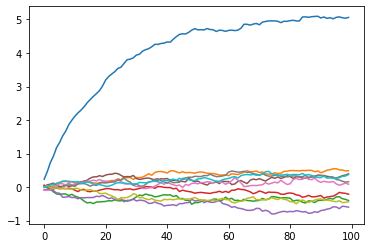

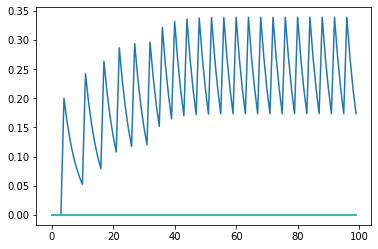

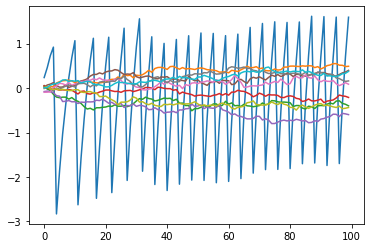

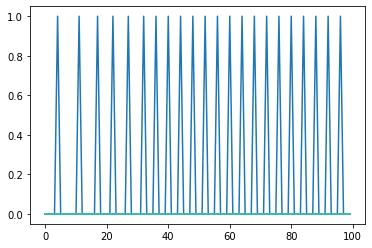

In [11]:
plt.figure()



plt.plot(v_hist)
plt.figure()
plt.plot(r_hist)
plt.figure()
plt.plot(v_hist - layer.rho * r_hist)
plt.figure()
plt.plot(out);

In [12]:
v_hist.sum(0)

array([404.5163  ,  35.29013 , -34.276688, -12.192227, -49.649685,
        22.593233,  11.477395,  23.07379 , -30.68233 ,  22.912466],
      dtype=float32)

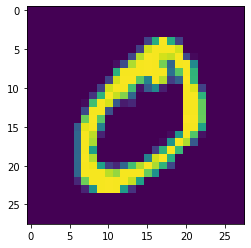

In [13]:
plt.imshow(sample[0])